In [1]:
from tqdm.auto import tqdm

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [2]:
from src.dataset import AudioFolder
from torch.utils.data import DataLoader

In [3]:
sr = 16000
train_set = AudioFolder("dataset/train/", sr=sr, n_data=500, slice_dur=3.3)
trainloader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

test_set = AudioFolder("dataset/valid/", sr=sr, n_data=200, slice_dur=2.4)
testloader = DataLoader(test_set, batch_size=128, num_workers=2)

# Architecture & Config

In [4]:
from src.model import SpeakerDiarization

In [5]:
config = set_config({
    "n_input": train_set.n_mel,
    "n_output": len(train_set.classes),
    "n_hidden": 256,
    "n_layer": 5,
    "dropout": 0.2,
    "audio_params": train_set.audio_params,
    "classes": train_set.classes
})

# Training Preparation -> MCOC

In [16]:
model = SpeakerDiarization(config.n_input, config.n_output, config.n_hidden, config.n_layer, config.dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training



Epoch     1
Train_cost  = 0.9493 | Test_cost  = 0.6919 | 




Epoch     2
Train_cost  = 0.4813 | Test_cost  = 0.3747 | 




Epoch     3
Train_cost  = 0.2825 | Test_cost  = 0.2378 | 




Epoch     4
Train_cost  = 0.1834 | Test_cost  = 0.1420 | 




Epoch     5
Train_cost  = 0.1092 | Test_cost  = 0.1166 | 




Epoch     6
Train_cost  = 0.0727 | Test_cost  = 0.0741 | 




Epoch     7
Train_cost  = 0.0524 | Test_cost  = 0.0568 | 




Epoch     8
Train_cost  = 0.0417 | Test_cost  = 0.0514 | 




Epoch     9
Train_cost  = 0.0338 | Test_cost  = 0.0400 | 




Epoch    10
Train_cost  = 0.0315 | Test_cost  = 0.0510 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0400




Epoch    11
Train_cost  = 0.0258 | Test_cost  = 0.0348 | 




Epoch    12
Train_cost  = 0.0230 | Test_cost  = 0.0400 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0348




Epoch    13
Train_cost  = 0.0206 | Test_cost  = 0.0335 | 




Epoch    14
Train_cost  = 0.0183 | Test_cost  = 0.0323 | 




Epoch    15
Train_cost  = 0.0192 | Test_cost  = 0.0365 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0323




Epoch    16
Train_cost  = 0.0187 | Test_cost  = 0.0300 | 




Epoch    17
Train_cost  = 0.0177 | Test_cost  = 0.0374 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0300




Epoch    18
Train_cost  = 0.0177 | Test_cost  = 0.0491 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0300




Epoch    19
Train_cost  = 0.0175 | Test_cost  = 0.0285 | 




Epoch    20
Train_cost  = 0.0158 | Test_cost  = 0.0463 | 


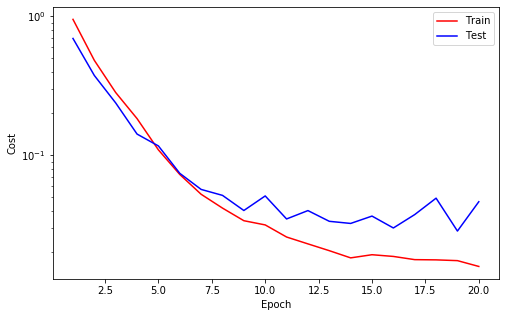

==> EarlyStop patience =  1 | Best test_cost: 0.0285




Epoch    21
Train_cost  = 0.0134 | Test_cost  = 0.0335 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0285




Epoch    22
Train_cost  = 0.0117 | Test_cost  = 0.0357 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0285




Epoch    23
Train_cost  = 0.0129 | Test_cost  = 0.0394 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0285




Epoch    24
Train_cost  = 0.0113 | Test_cost  = 0.0353 | 
==> EarlyStop patience =  5 | Best test_cost: 0.0285
==> Execute Early Stopping at epoch: 24 | Best test_cost: 0.0285
==> Best model is saved at model


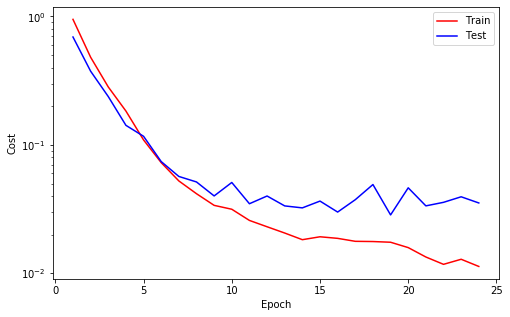

In [17]:
while True:
    model.train()
    cost = 0
    for specs, labels in tqdm(trainloader, desc="Train"):
        specs, labels = specs.to(device), labels.to(device)
        
        output, _ = model(specs, None)
        loss = criterion(output, labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        cost += loss.item()*specs.shape[0]
    train_cost = cost/len(train_set)
    
    with torch.no_grad():
        model.eval()
        cost = 0
        for specs, labels in tqdm(testloader, desc="Test"):
            specs, labels = specs.to(device), labels.to(device)
        
            output, _ = model(specs, None)
            loss = criterion(output, labels)
            
            cost += loss.item()*specs.shape[0]
        test_cost = cost/len(test_set)

    # Logging
    callback.log(train_cost, test_cost)
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break